In [10]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
# import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
import matplotlib.pyplot as plt

In [11]:
data = 'data'

In [12]:
# sets = os.listdir(data)
# class_names = os.listdir(os.path.join(data,sets[0]))
# class_paths = [os.path.join(data, cls) for cls in class_names]

In [13]:
# file_paths = []
# labels = []

In [14]:
# for idx, class_path in enumerate(class_paths):
#     files = os.listdir(class_path)
#     file_paths.extend([os.path.join(class_path, file) for file in files])
#     labels.extend([idx] * len(files))

In [15]:
# np.array(labels).shape

In [16]:
# Split the data into train and test sets
# train_files, test_files, train_labels, test_labels = train_test_split(file_paths, labels, test_size=0.2, random_state=42)

In [17]:
# # Define the EfficientNetV2 model from TensorFlow Hub
# efficientnetv2_url = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2'
# efficientnetv2 = hub.KerasLayer(efficientnetv2_url,
#                                 trainable=True,)

In [18]:
# Define data augmentation for both training and validation data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # shear_range=0.2,
    zoom_range=0.2,
    brightness_range= (0.8,1.0),
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    rotation_range = 15,
    horizontal_flip=True,
    vertical_flip=True
    # validation_split=0.2  # 20% validation split
)
val_datagen= ImageDataGenerator(rescale=1./255,    horizontal_flip=True,
    vertical_flip=True)


# Set the target image size
target_size = (384, 384)  # Adjust based on your EfficientNetV2 input size
batch_size = 8

# Create train and validation generators
train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=target_size,
    batch_size= batch_size,
    class_mode='categorical',
)

validation_generator = val_datagen.flow_from_directory(
    'data/val',
    target_size=target_size,
    batch_size= batch_size,
    class_mode='categorical',
)

Found 821 images belonging to 10 classes.
Found 201 images belonging to 10 classes.


In [19]:
class_names = [key for key in train_generator.class_indices]

print(class_names)

['Brown Plant Hopper', 'False Smut', 'Green Leaf Hopper', 'Healthy', 'LeafBlast_rice', 'Sheath Blight', 'Stem Borer', 'Tungro_', 'Yellow Stem Borer', 'bacterial_leaf_blight']


In [20]:
efficientnetv2 = tf.keras.applications.efficientnet_v2.EfficientNetV2S(
                include_top=False,
                weights='imagenet',
                input_tensor=None,
                input_shape=target_size+(3,),
                pooling='avg',
                # classes=1000,
                # classifier_activation='softmax',
            )

In [14]:
for layer in efficientnetv2.layers:
    layer.trainable = True

In [15]:
# Create a new model on top of EfficientNetV2
model = tf.keras.Sequential()

# model.add(tf.keras.layers.Input(target_size+(3,)))
model.add(efficientnetv2)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1024, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1024, activation = 'relu'))
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(1024, activation = 'relu'))
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(1024, activation = 'relu'))
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(512, activation = 'relu'))
# model.add( tf.keras.layers.Dense(64, activation = 'softmax'))
# model.add( tf.keras.layers.Dense(32, activation = 'softmax'))
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 1280)             20331360  
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1

In [17]:

model.compile(optimizer=tf.keras.optimizers.RMSprop(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:

# Define early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=1e-8)
es = EarlyStopping(monitor='val_loss', patience=7, mode="min", restore_best_weights=True)

In [19]:

history = model.fit(train_generator, epochs=256, 
                validation_data=validation_generator, 
                verbose=1, 
                callbacks=[es, reduce_lr])

Epoch 1/256
103/103 [==============================] - 93s 538ms/step - loss: 1.4570 - accuracy: 0.4896 - val_loss: 1.3512 - val_accuracy: 0.6816 - lr: 1.0000e-04
Epoch 2/256
103/103 [==============================] - 51s 492ms/step - loss: 0.7914 - accuracy: 0.6943 - val_loss: 0.6247 - val_accuracy: 0.8209 - lr: 1.0000e-04
Epoch 3/256
103/103 [==============================] - 51s 493ms/step - loss: 0.6271 - accuracy: 0.7722 - val_loss: 0.4068 - val_accuracy: 0.8557 - lr: 1.0000e-04
Epoch 4/256
103/103 [==============================] - 51s 489ms/step - loss: 0.4771 - accuracy: 0.8417 - val_loss: 0.3825 - val_accuracy: 0.8607 - lr: 1.0000e-04
Epoch 5/256
103/103 [==============================] - 50s 486ms/step - loss: 0.4111 - accuracy: 0.8526 - val_loss: 0.3874 - val_accuracy: 0.8756 - lr: 1.0000e-04
Epoch 6/256
103/103 [==============================] - 52s 501ms/step - loss: 0.4245 - accuracy: 0.8672 - val_loss: 0.3723 - val_accuracy: 0.8557 - lr: 1.0000e-04
Epoch 7/256
103/103 [=

In [20]:
es = EarlyStopping(monitor='loss', patience=5, mode="min", restore_best_weights=True)
history2 = model.fit(train_generator, epochs=1, 
                validation_data=validation_generator, 
                verbose=1, 
                callbacks=[es, reduce_lr])

103/103 [==============================] - 46s 447ms/step - loss: 0.1319 - accuracy: 0.9525 - val_loss: 0.1807 - val_accuracy: 0.9353 - lr: 1.0000e-07


In [21]:

## General save path
version = len(os.listdir('models'))
save_path = 'models/classifier_v{:d}/'.format(version)
os.mkdir(save_path)

In [22]:
## Best model saved
train_loss = history.history['loss'] + history2.history['loss']
train_accuracy = history.history['accuracy'] + history2.history['accuracy']
val_loss = history.history['val_loss'] + history2.history['val_loss']
val_accuracy = history.history['val_accuracy'] + history2.history['val_accuracy']

best_epoch = np.argmin(np.array(val_loss))

print("Best Epoch: ", best_epoch)
print("Final Train Loss: {:.4f}".format(train_loss[best_epoch]))
print("Final Validation Loss: {:.4f}".format(val_loss[best_epoch]))
print("Final Train accuracy: {:.2f}".format(train_accuracy[best_epoch]*100))
print("Final Test accuracy: {:.2f}".format(val_accuracy[best_epoch]*100))

Best Epoch:  15
Final Train Loss: 0.1526
Final Validation Loss: 0.1394
Final Train accuracy: 94.64
Final Test accuracy: 94.03


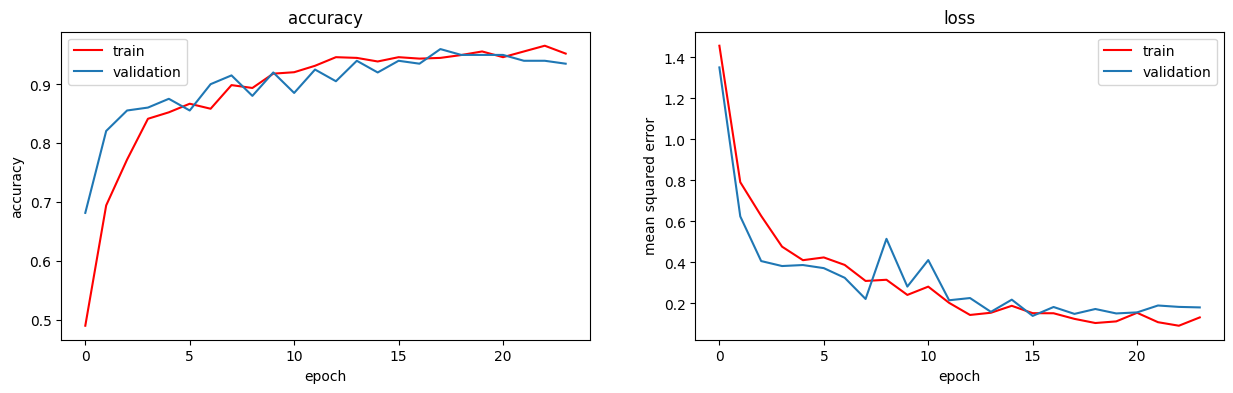

In [23]:
# Saving the figure.
## Graphing Result of training
x_ticks = [i for i in range(len(history.history['loss']+ history2.history['loss']))  if i%5==0 ]
plt.figure(figsize=(15,4))

plt.subplot(121)
plt.plot(history.history['accuracy']+ history2.history['accuracy'], color ='r')
plt.plot(history.history['val_accuracy']+ history2.history['val_accuracy'])
plt.title('accuracy')
plt.legend(['train','validation'])
plt.xticks(x_ticks)
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.subplot(122)
plt.plot(history.history['loss']+ history2.history['loss'], color ='r')
plt.plot(history.history['val_loss']+ history2.history['val_loss'])
plt.title('loss')
plt.legend(['train','validation'])
plt.xticks(x_ticks)
plt.xlabel('epoch')
plt.ylabel('mean squared error')

plt.savefig(save_path+"plots.jpg")

In [24]:

## Save best metrics
with open(save_path+'metrics.txt', 'w') as f:
    f.write("Best Epoch: {:d} \n".format(best_epoch))
    f.write("Final Train Loss: {:.4f}\n".format(train_loss[best_epoch]))
    f.write("Final Validation Loss: {:.4f}\n".format(val_loss[best_epoch]))
    f.write("Final Train accuracy: {:.2f}%\n".format(train_accuracy[best_epoch]*100))
    f.write("Final Test accuracy: {:.2f}%\n".format(val_accuracy[best_epoch]*100))

Save the model

In [25]:
## saving model
model.save(save_path+'model.h5')

In [26]:
from tensorflow.keras.preprocessing import image
import numpy as np

def load_and_preprocess_image(image_path, target_size):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array *= 1./255
    return img_array

In [27]:

image_path = 'data/train/bacterial_leaf_blight/BLB (13).png'


input_image = load_and_preprocess_image(image_path, target_size=target_size)


predictions = model.predict(input_image)

print(class_names[np.argmax(predictions[0])])
print('probability {:.4f}'.format(predictions[0][np.argmax(predictions[0])]))

1/1 [==============================] - 3s 3s/step
bacterial_leaf_blight
probability 1.0000


In [28]:
image_path = 'data/train/Yellow Stem Borer/4 (3).png'


input_image = load_and_preprocess_image(image_path, target_size=target_size)


predictions = model.predict(input_image)

print(class_names[np.argmax(predictions[0])])
print('probability {:.4f}'.format(predictions[0][np.argmax(predictions[0])]))

1/1 [==============================] - 0s 28ms/step
Yellow Stem Borer
probability 1.0000


In [29]:
import tensorflow as tf

In [30]:
# Create a new model on top of EfficientNetV2
model = tf.keras.Sequential()

# model.add(tf.keras.layers.Input(target_size+(3,)))
model.add(efficientnetv2)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1024, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1024, activation = 'relu'))
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(1024, activation = 'relu'))
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(1024, activation = 'relu'))
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(512, activation = 'relu'))
# model.add( tf.keras.layers.Dense(64, activation = 'softmax'))
# model.add( tf.keras.layers.Dense(32, activation = 'softmax'))
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))


In [31]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
model.load_weights(filepath='models/model_weights/')

In [33]:
model.predict(next(train_generator)[0])

1/1 [==============================] - 2s 2s/step


array([[2.97507108e-06, 4.40772692e-06, 4.09847416e-06, 9.98870552e-01,
        1.08670921e-03, 1.80848087e-06, 5.02181649e-07, 1.71745796e-05,
        5.62886044e-06, 6.21496656e-06],
       [5.67556446e-10, 7.23127469e-09, 1.15919174e-09, 1.93119973e-08,
        2.65811095e-10, 8.70937419e-11, 7.11432802e-10, 9.99999642e-01,
        2.90231498e-07, 1.00247055e-08],
       [1.03324715e-09, 1.00000000e+00, 1.35794986e-09, 1.18922001e-08,
        3.46790929e-10, 6.87737201e-10, 1.01947020e-08, 6.62132971e-09,
        2.18934182e-09, 1.73513162e-10],
       [2.05147194e-06, 3.60815216e-06, 1.30951257e-05, 3.45910375e-05,
        1.76701462e-04, 5.63646143e-04, 6.88989076e-07, 9.98427153e-01,
        1.96737266e-04, 5.81753382e-04],
       [6.51029808e-08, 3.36810416e-07, 2.66234359e-08, 3.25697802e-05,
        6.20179605e-07, 1.02287629e-07, 3.05050071e-06, 9.99936104e-01,
        2.62609610e-05, 8.16185377e-07],
       [1.19992521e-07, 8.72356281e-07, 1.26812921e-07, 2.08951988e-07,
   

In [34]:
model.save(filepath='models/model.h5')

In [35]:
model = tf.keras.models.load_model('models/model.h5')

In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 1280)             20331360  
 l)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 1024)              1311744   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)             

# Final Model

In [37]:
# import os
# import shutil

# # Define the paths
# base_dir = 'data'
# train_dir = os.path.join(base_dir, 'train')
# val_dir = os.path.join(base_dir, 'val')
# all_dir = os.path.join(base_dir, 'all')

# # Create the 'all' directory if it doesn't exist
# os.makedirs(all_dir, exist_ok=True)

# # Get the list of class directories from the 'train' folder
# classes = os.listdir(train_dir)

# # Function to merge contents of train and val into all
# def merge_classes(train_path, val_path, all_path):
#     for item in os.listdir(train_path):
#         s = os.path.join(train_path, item)
#         d = os.path.join(all_path, item)
#         shutil.copy2(s, d)
#     for item in os.listdir(val_path):
#         s = os.path.join(val_path, item)
#         d = os.path.join(all_path, item)
#         shutil.copy2(s, d)

# # Loop through each class and merge files
# for class_name in classes:
#     train_class_dir = os.path.join(train_dir, class_name)
#     val_class_dir = os.path.join(val_dir, class_name)
#     all_class_dir = os.path.join(all_dir, class_name)

#     # Create class directory in 'all'
#     os.makedirs(all_class_dir, exist_ok=True)

#     # Merge the contents of 'train' and 'val' into 'all'
#     merge_classes(train_class_dir, val_class_dir, all_class_dir)

# print("Merging completed successfully.")


In [40]:
# Define data augmentation for both training and validation data
all_datagen = ImageDataGenerator(
    rescale=1./255,
    # shear_range=0.2,
    zoom_range=0.2,
    brightness_range= (0.8,1.0),
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    rotation_range = 15,
    horizontal_flip=True,
    vertical_flip=True
    # validation_split=0.2  # 20% validation split
)


# Set the target image size
target_size = (384, 384)  # Adjust based on your EfficientNetV2 input size
batch_size = 8

# Create train and validation generators
all_generator = all_datagen.flow_from_directory(
    'data/all',
    target_size=target_size,
    batch_size= batch_size,
    class_mode='categorical',
)

Found 1022 images belonging to 10 classes.


In [42]:
# Create a new model on top of EfficientNetV2
model = tf.keras.Sequential()

# model.add(tf.keras.layers.Input(target_size+(3,)))
model.add(efficientnetv2)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1024, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1024, activation = 'relu'))
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(1024, activation = 'relu'))
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(1024, activation = 'relu'))
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(512, activation = 'relu'))
# model.add( tf.keras.layers.Dense(64, activation = 'softmax'))
# model.add( tf.keras.layers.Dense(32, activation = 'softmax'))
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.RMSprop(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
# Define early stopping
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=3, min_lr=1e-8)
es = EarlyStopping(monitor='loss', patience=7, mode="min", restore_best_weights=True)
history = model.fit(all_generator, epochs=256, 
                verbose=1, 
                callbacks=[es, reduce_lr])
## General save path
version = len(os.listdir('models'))
save_path = 'models/classifier_v{:d}/'.format(version)
os.mkdir(save_path)

Epoch 1/256
128/128 [==============================] - 81s 444ms/step - loss: 0.2942 - accuracy: 0.9364 - lr: 1.0000e-04
Epoch 2/256
128/128 [==============================] - 56s 439ms/step - loss: 0.0568 - accuracy: 0.9873 - lr: 1.0000e-04
Epoch 3/256
128/128 [==============================] - 57s 446ms/step - loss: 0.0567 - accuracy: 0.9824 - lr: 1.0000e-04
Epoch 4/256
128/128 [==============================] - 57s 446ms/step - loss: 0.0758 - accuracy: 0.9775 - lr: 1.0000e-04
Epoch 5/256
128/128 [==============================] - 57s 444ms/step - loss: 0.0900 - accuracy: 0.9765 - lr: 1.0000e-04
Epoch 6/256
128/128 [==============================] - 57s 445ms/step - loss: 0.0567 - accuracy: 0.9853 - lr: 1.0000e-05
Epoch 7/256
128/128 [==============================] - 57s 446ms/step - loss: 0.0371 - accuracy: 0.9912 - lr: 1.0000e-05
Epoch 8/256
128/128 [==============================] - 58s 448ms/step - loss: 0.0571 - accuracy: 0.9883 - lr: 1.0000e-05
Epoch 9/256
128/128 [===========

In [46]:
save_path

'models/classifier_v5/'

Best Epoch:  15
Final Train Loss: 0.0184
Final Train accuracy: 99.51


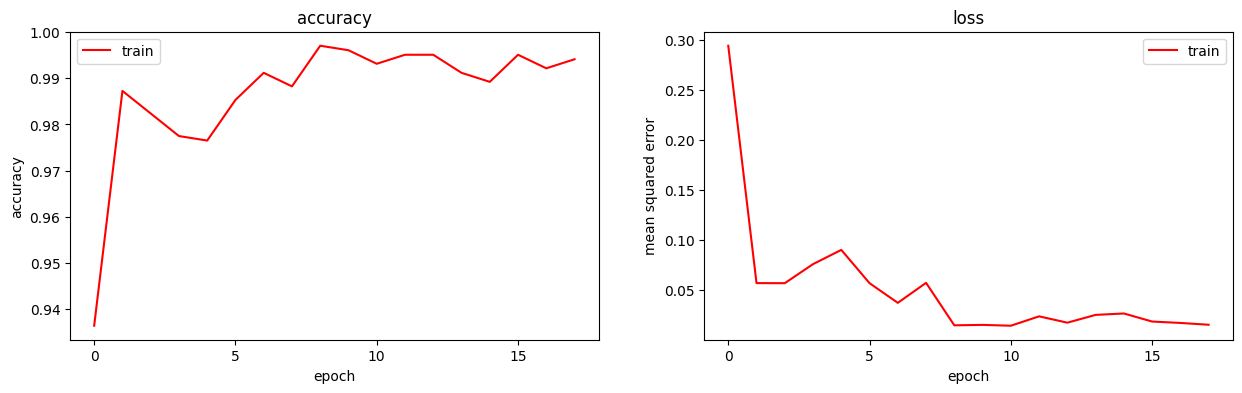

In [43]:
## Best model saved
train_loss = history.history['loss'] 
train_accuracy = history.history['accuracy'] 

best_epoch = np.argmin(np.array(val_loss))

print("Best Epoch: ", best_epoch)
print("Final Train Loss: {:.4f}".format(train_loss[best_epoch]))
print("Final Train accuracy: {:.2f}".format(train_accuracy[best_epoch]*100))
## Graphing Result of training
x_ticks = [i for i in range(len(history.history['loss']))  if i%5==0 ]
plt.figure(figsize=(15,4))

plt.subplot(121)
plt.plot(history.history['accuracy'], color ='r')
plt.title('accuracy')
plt.legend(['train'])
plt.xticks(x_ticks)
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.subplot(122)
plt.plot(history.history['loss'], color ='r')
plt.title('loss')
plt.legend(['train'])
plt.xticks(x_ticks)
plt.xlabel('epoch')
plt.ylabel('mean squared error')

plt.savefig(save_path+"plots.jpg")
## Save best metrics
with open(save_path+'metrics_final.txt', 'w') as f:
    f.write("Best Epoch: {:d} \n".format(best_epoch))
    f.write("Final Train Loss: {:.4f}\n".format(train_loss[best_epoch]))
    f.write("Final Train accuracy: {:.2f}%\n".format(train_accuracy[best_epoch]*100))

In [44]:
## saving model
model.save(save_path+'model.h5')

In [3]:
import tensorflow as tf

model = tf.keras.models.load_model("models\classifier_v5\model.h5")

In [21]:
from tensorflow.keras.preprocessing import image
import numpy as np

def load_and_preprocess_image(image_path, target_size):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array *= 1./255
    return img_array

image_path = 'data/train/bacterial_leaf_blight/BLB (13).png'


input_image = load_and_preprocess_image(image_path, target_size=(384, 384))


predictions = model.predict(input_image)

print(class_names[np.argmax(predictions[0])])
print('probability {:.4f}'.format(predictions[0][np.argmax(predictions[0])]))

1/1 [==============================] - 0s 29ms/step
bacterial_leaf_blight
probability 1.0000
